# The second version of EDA

In [281]:
# Imports
import pandas as pd
import config as conf
import matplotlib.pyplot as plt
from os.path import join
from PIL import Image
import cv2
import numpy as np
from scipy.stats import entropy
import random

In [282]:
df = pd.read_csv(conf.CSV_FILE)

df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


## Calculating mean ship size in dataset

In [283]:
def calc_ship_size(encoded_pixels: str) -> int:
    if not isinstance(encoded_pixels, str):
        return 0
    
    shifts = encoded_pixels.split(" ")
    
    sum = 0
    for i in range(1, len(shifts), 2):
        sum += int(shifts[i])
    
    return sum    


In [284]:
ship_occurances = df["EncodedPixels"].apply(calc_ship_size)

print(f"The mean ship occurance area in dataset - {ship_occurances.mean()}")

The mean ship occurance area in dataset - 552.7868005627433


In [285]:
images_with_ships_df = df[~df["EncodedPixels"].isnull()]
empty_images_df = df[df["EncodedPixels"].isnull()]

ship_sizes = images_with_ships_df["EncodedPixels"].apply(calc_ship_size)

mean_size = ship_sizes.mean()
size_std = ship_sizes.std()

print("Mean ship size", round(mean_size, 2))
print("Min ship size", ship_sizes.min())
print("Max ship size", ship_sizes.max())
print("Ship size standart deviation", round(size_std, 2))

Mean ship size 1567.4
Min ship size 2
Max ship size 25904
Ship size standart deviation 2842.08


In [286]:
counts = ship_sizes.value_counts()

most_frequent_value = counts.idxmax()
least_frequent_value = counts.idxmin()

print(most_frequent_value)
print(least_frequent_value)

36
12886


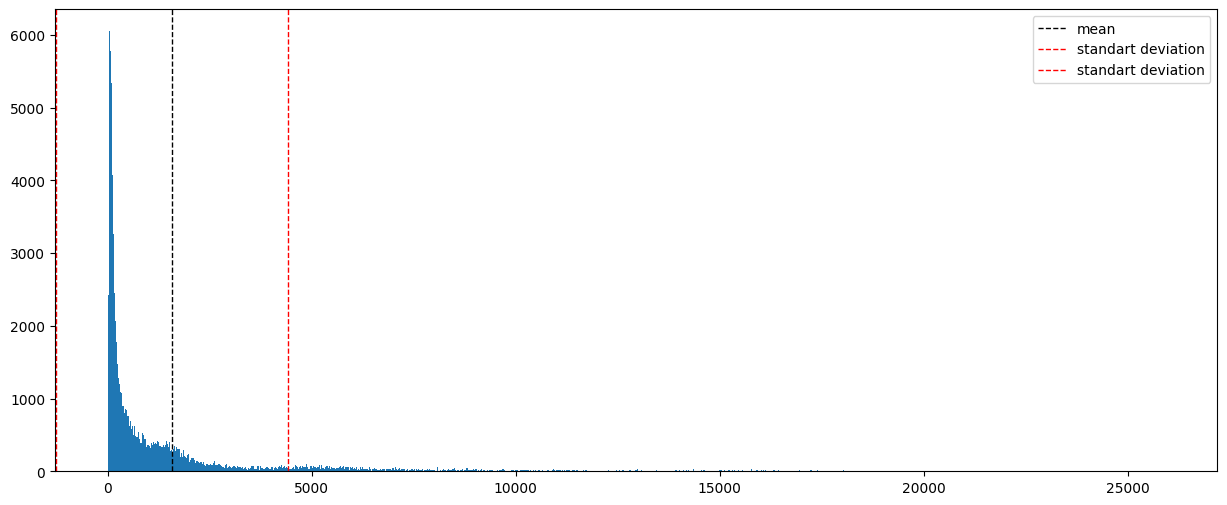

In [287]:
plt.figure(figsize=(15, 6))

plt.hist(ship_sizes, bins=1000)
plt.axvline(mean_size, color='k', linestyle='dashed', linewidth=1, label="mean")
plt.axvline(mean_size + size_std , color='r', linestyle='dashed', linewidth=1, label="standart deviation")
plt.axvline(mean_size - size_std , color='r', linestyle='dashed', linewidth=1, label="standart deviation")
plt.legend()
plt.show()

#### The results:
1) The mean ship occurance area in dataset - 552.78
2) The mean ship area - 1567.4
3) Minimal ship size - 2
4) Maximum ship size - 25904
5) Ship size standart deviation - 2842.08
6) Ship most and least frequent area values - 36, 12886

## Calculating part of empty images

In [288]:
all_df_size = len(df)
all_df_size

231722

In [289]:
empty_images_size = all_df_size - len(images_with_ships_df)
empty_images_size

149999

In [290]:
empty_images_part = empty_images_size / all_df_size
empty_images_part

0.6473230854213238

The part of empty images is 64.73% 

#### Results:
1) Size of dataset - 231722
2) Number of images without a ship - 149999
3) Part of images without a ship - 64.73%

## Trunkated values search

In [291]:
def is_truncated_image(image_id):
    try:
        Image.open(join(conf.IMAGES_DIR, image_id)).load()
    except OSError as e:
        print(e, image_id)
        return True
    return False 

In [292]:
if conf.REMOVE_TRUNCATED_IMAGES:
    df["truncated"] = df["ImageId"].apply(is_truncated_image)

    print(f"Truncated images in whole dataframe - {df['truncated'].sum()}")
    df["truncated"].head()
    df = df[~df["truncated"]]
    df.drop("truncated")


## Fourier Transform 

In [293]:
def image_fft(image_name):
    img = cv2.imread(image_name, 0)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift))

    plt.subplot(121), plt.imshow(img, cmap = 'gray')
    plt.title('Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(magnitude_spectrum, cmap = 'gray')
    plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
    plt.show()

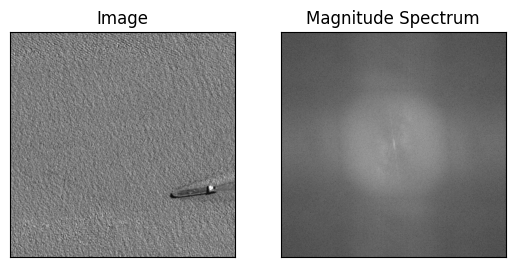

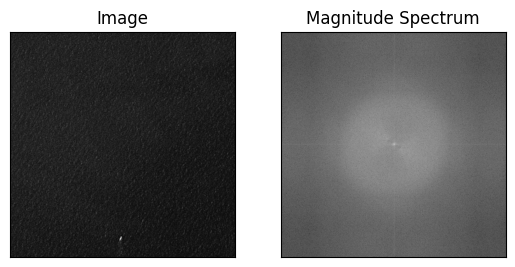

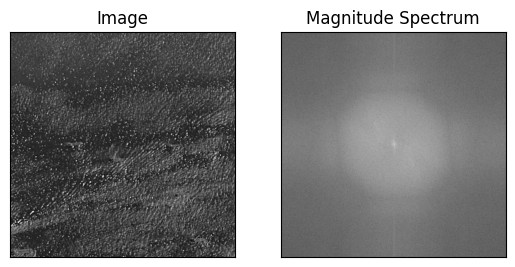

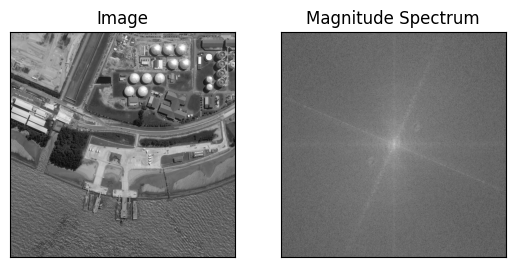

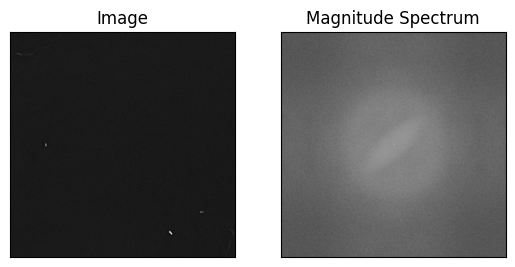

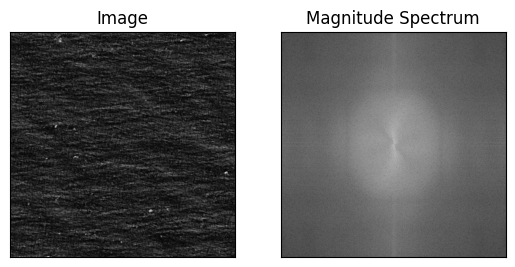

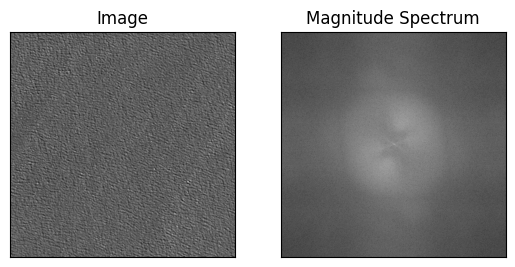

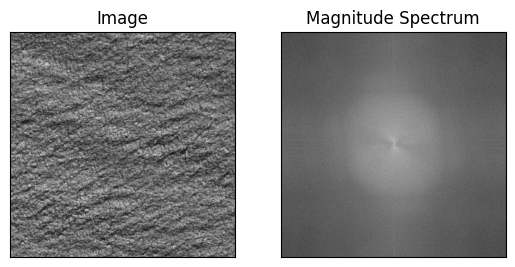

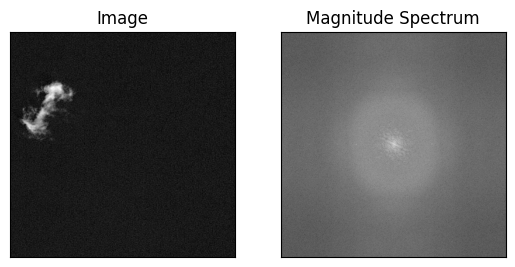

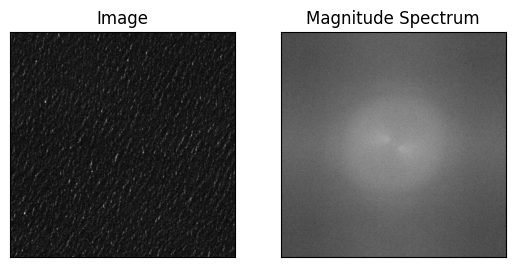

In [294]:
ship_images = images_with_ships_df.sample(5)
empty_images = empty_images_df.sample(5)

for image_id in ship_images["ImageId"]:
    image_name = join(conf.IMAGES_DIR, image_id)
    image_fft(image_name)


for image_id in empty_images["ImageId"]:
    image_name = join(conf.IMAGES_DIR, image_id)
    image_fft(image_name)



## Image Entropy

In [295]:
def get_image_entropy(image_id: str, plot=False) -> float: 
    image = cv2.imread(join(conf.IMAGES_DIR, image_id))
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if plot:
        plt.imshow(gray_image, cmap="grey")

    _bins = 128

    hist, _ = np.histogram(gray_image.ravel(), bins=_bins, range=(0, _bins))
    prob_dist = hist / hist.sum()
    image_entropy = entropy(prob_dist, base=2)
    
    return image_entropy


C:\Users\max\AppData\Local\Temp\ipykernel_9980\273840044.py:11: RuntimeWarning: invalid value encountered in divide
  prob_dist = hist / hist.sum()


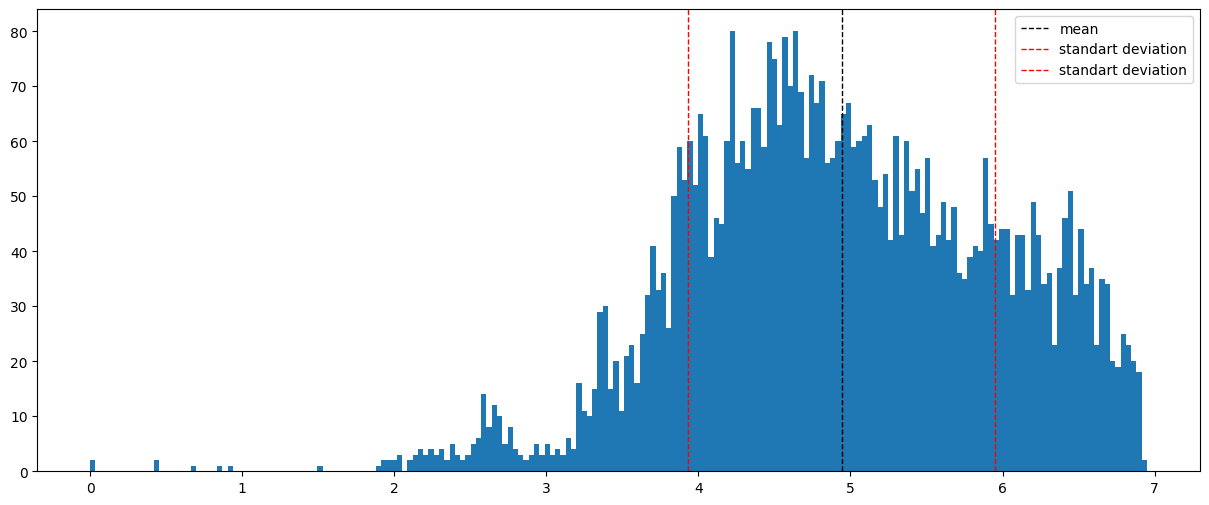

In [299]:
image_entropies = images_with_ships_df["ImageId"].sample(5000).apply(get_image_entropy)

mean_entropy = image_entropies.mean()
std_entropy = image_entropies.std()

plt.figure(figsize=(15, 6))

plt.hist(image_entropies, bins=200)
plt.axvline(mean_entropy, color='k', linestyle='dashed', linewidth=1, label="mean")
plt.axvline(mean_entropy + std_entropy , color='r', linestyle='dashed', linewidth=1, label="standart deviation")
plt.axvline(mean_entropy - std_entropy, color='r', linestyle='dashed', linewidth=1, label="standart deviation")
plt.legend()
plt.show()

C:\Users\max\AppData\Local\Temp\ipykernel_9980\273840044.py:11: RuntimeWarning: invalid value encountered in divide
  prob_dist = hist / hist.sum()


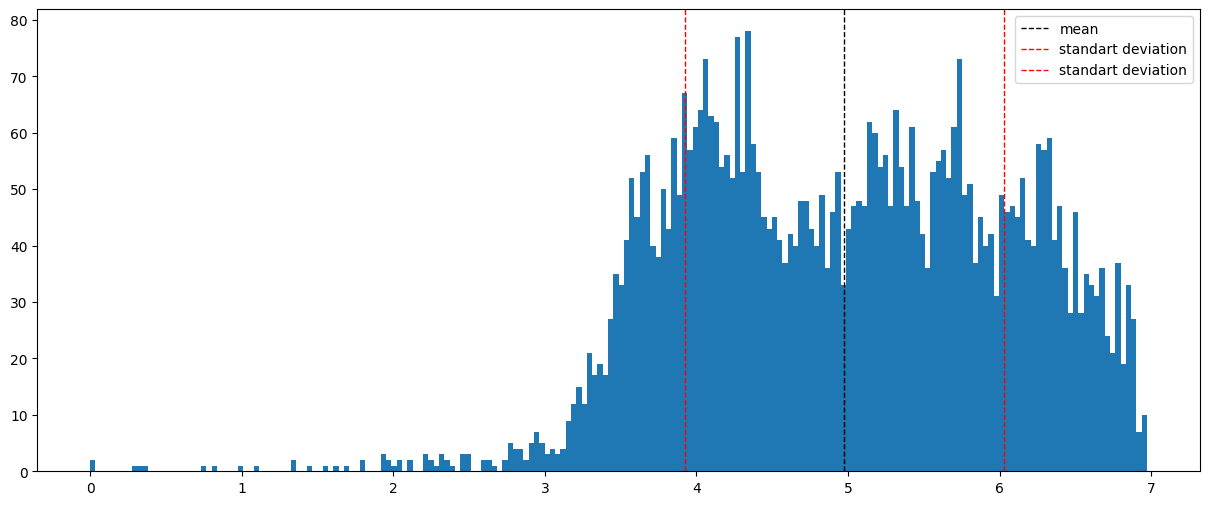

In [300]:
image_entropies = empty_images_df["ImageId"].sample(5000).apply(get_image_entropy)

mean_entropy = image_entropies.mean()
std_entropy = image_entropies.std()

plt.figure(figsize=(15, 6))

plt.hist(image_entropies, bins=200)
plt.axvline(mean_entropy, color='k', linestyle='dashed', linewidth=1, label="mean")
plt.axvline(mean_entropy + std_entropy , color='r', linestyle='dashed', linewidth=1, label="standart deviation")
plt.axvline(mean_entropy - std_entropy, color='r', linestyle='dashed', linewidth=1, label="standart deviation")
plt.legend()
plt.show()